Эксперименты по решению дифференциальных уравнений с периодическими г.у. при помощи PINN

Подход из статьи ( Sifan Wang, Shyam Sankaran ) Respecting causality is all you need for training physics-informed neural networks

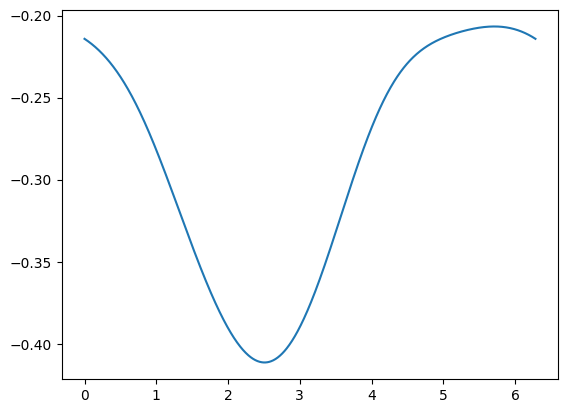

epoch =      1, loss = 5.5005e-01, err_r_l2 = 1.5397e-01, err_bc_l2 = 3.0455e-02, res_l2 = 5.5005e-01
epoch =    100, loss = 1.2588e-04, err_r_l2 = 2.8032e-06, err_bc_l2 = 3.7477e-06, res_l2 = 1.2588e-04
epoch =    200, loss = 3.9394e-05, err_r_l2 = 1.3919e-06, err_bc_l2 = 3.3271e-07, res_l2 = 3.9394e-05
epoch =    300, loss = 2.0930e-05, err_r_l2 = 9.8842e-08, err_bc_l2 = 5.1640e-07, res_l2 = 2.0930e-05
epoch =    400, loss = 1.2084e-05, err_r_l2 = 4.3003e-07, err_bc_l2 = 1.7980e-06, res_l2 = 1.2084e-05
epoch =    500, loss = 6.6223e-06, err_r_l2 = 3.9902e-07, err_bc_l2 = 1.7611e-07, res_l2 = 6.6223e-06
epoch =    600, loss = 4.4892e-06, err_r_l2 = 1.2712e-07, err_bc_l2 = 6.0880e-09, res_l2 = 4.4892e-06
epoch =    700, loss = 3.7627e-06, err_r_l2 = 2.1464e-07, err_bc_l2 = 4.4191e-08, res_l2 = 3.7627e-06
epoch =    800, loss = 6.1977e-06, err_r_l2 = 4.1769e-07, err_bc_l2 = 2.6061e-07, res_l2 = 6.1977e-06
epoch =    900, loss = 2.6959e-06, err_r_l2 = 9.2775e-09, err_bc_l2 = 3.2039e-09, 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

def init_weights(m):
    if isinstance(m, nn.Linear):
        #nn.init.xavier_normal_(m.weight)  # или другой метод
        nn.init.kaiming_normal_(m.weight, nonlinearity='tanh')
        #m.weight.data *= 10
        nn.init.constant_(m.bias, 0.5)
        #m.bias.data += 0.05 * torch.randn_like(m.bias)

class PeriodicLayer(nn.Module):
    """
    Periodic layer recreating from the article:
    ( Sifan Wang, Shyam Sankaran ) Respecting causality is all you need for training physics-informed neural networks
    """
    def __init__(self, m: int, omega: float):
        super().__init__()
        self.m = m
        self.omega = omega

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (n, 1)
        Возвращает: ((2*m + 1)*n, 1)
        """
        n = x.shape[0]
        features = [torch.ones_like(x)]
        for k in range(1, self.m + 1):
            features.append(torch.sin(k * self.omega * x))
            features.append(torch.cos(k * self.omega * x))
        #out = torch.cat(features, dim=1)   # (n, 2*m + 1)
        #out = out.reshape(-1, 1)           # ((2*m + 1)*n, 1)
        return torch.cat(features, dim=1)
    
u_exact = lambda x: -1.0/2.0 * torch.sin(x)

# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЯ И ЕГО ЗАПУСК ---
domain = [0, 2.0*torch.pi]
n = 100
m = 1
n_epochs = 5000

device = 'cpu'
torch.manual_seed(2008)
model = nn.Sequential(
    PeriodicLayer(m, 1.0), 
    nn.Linear(2*m + 1, 256), nn.Tanh(),
    nn.Linear(256, 1)
).to(device=device)

#model.apply(init_weights)
x = torch.linspace(*domain, 1000).reshape(-1, 1)
plt.plot(x.detach(), model(x).detach())
plt.show()

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
loss = torch.zeros(n_epochs)
err_r_l2 = torch.zeros(n_epochs)
err_bc_l2 = torch.zeros(n_epochs)
res_l2 = torch.zeros(n_epochs)
x_bc = torch.tensor([[domain[0]], [domain[1]]], device=device)
for k in range(1, n_epochs + 1):
    x = (domain[1] - domain[0]) * torch.rand(n, 1, device=device) + domain[0]
    x.requires_grad_(True)
    u = model(x)
    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]

    optimizer.zero_grad()
    tmp_r = torch.mean((d2u_dx2 - u - torch.sin(x))**2)
    #loss_mean = torch.mean(u)**2          # encourage mean=0
    #loss_var  = (torch.var(u) - 1.0)**2  # encourage variance=1
    #tmp = tmp_r + loss_var
    tmp = tmp_r
    tmp.backward()
    optimizer.step()
    loss[k-1] = tmp.detach().cpu()

    with torch.no_grad():
        err_r = model(x) - u_exact(x)
        err_bc = model(x_bc) - u_exact(x_bc)
        err_r_l2[k-1] = torch.mean(err_r**2)
        err_bc_l2[k-1] = torch.mean(err_bc**2)
        res_l2[k-1] = torch.mean( ( d2u_dx2 - u - torch.sin(x) )**2 )

    if k == 1 or k % 100 == 0:
        print(f"epoch = {k:6d}, loss = {loss[k-1]:10.4e}, err_r_l2 = {err_r_l2[k-1]:10.4e}, err_bc_l2 = {err_bc_l2[k-1]:10.4e}, res_l2 = {res_l2[k-1]:10.4e}")


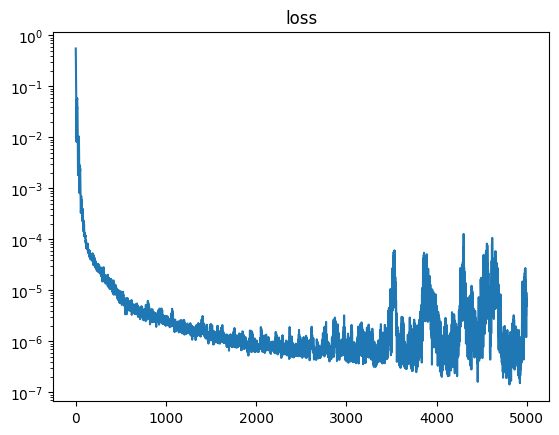

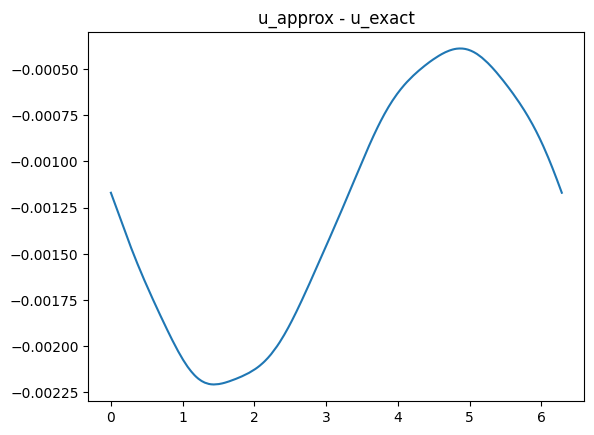

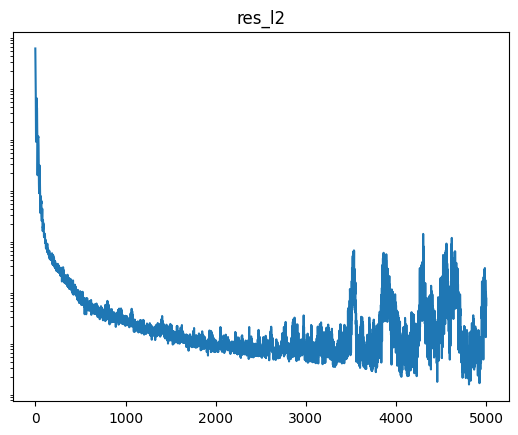

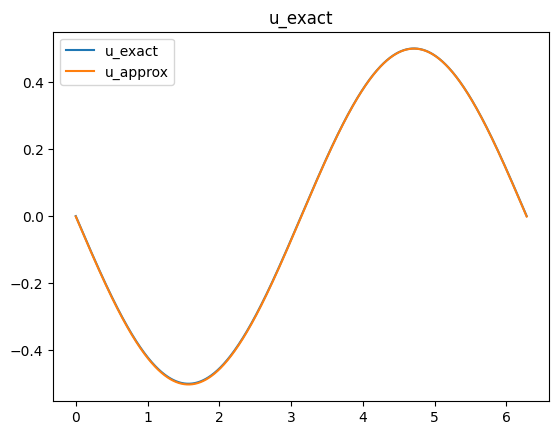

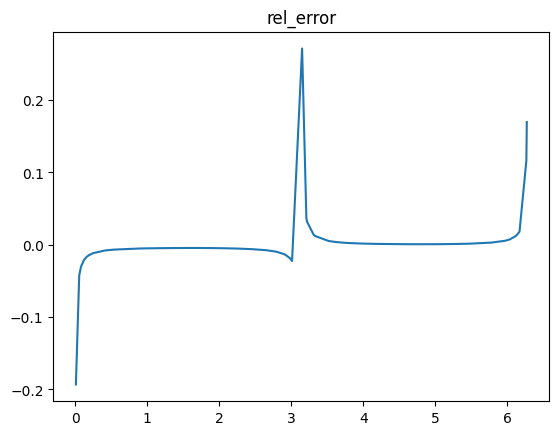

In [14]:
with torch.no_grad():
    plt.semilogy(loss)
    plt.title("loss")
    plt.show()

    model = model.to("cpu")
    x = torch.linspace(*domain, 1000).reshape(-1, 1)
    plt.plot(x, model(x) - u_exact(x))
    plt.title("u_approx - u_exact")
    plt.show()

    plt.plot(res_l2)
    plt.semilogy("res_l2")
    plt.title("res_l2")
    plt.show()

    plt.plot(x, u_exact(x), label="u_exact")
    plt.plot(x, model(x), label="u_approx")
    plt.title("u_exact")
    plt.legend()
    plt.show()

    x = (domain[1] - domain[0]) * torch.rand(100, 1, device=device) + domain[0]
    x, _ = torch.sort(x, dim=0)
    plt.plot(x, torch.abs(model(x) - u_exact(x)) / u_exact(x))
    plt.title("rel_error")
    plt.show()